In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
from random import sample
import sklearn.model_selection as skl
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50 
from keras.optimizers import Adam, RMSprop
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.utils.vis_utils import plot_model
from sklearn.metrics import roc_curve, auc, precision_recall_curve, classification_report, confusion_matrix 
import warnings
import seaborn as sns
warnings.filterwarnings("ignore")
import matplotlib.ticker as ticker
sns.set_style('whitegrid')
%matplotlib inline
import math

Using TensorFlow backend.


## Do some early processing of your metadata for easier model training:

In [2]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
13400,00003489_004.png,No Finding,4,3489,52,M,PA,2500,2048,0.168,0.168,NaN,/data/images_002/images/00003489_004.png
86175,00021252_000.png,Nodule,0,21252,35,M,PA,2992,2991,0.143,0.143,NaN,/data/images_010/images/00021252_000.png
88636,00021965_008.png,No Finding,8,21965,60,M,AP,2500,2048,0.168,0.168,NaN,/data/images_010/images/00021965_008.png


In [3]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column

# Reference
# https://www.kaggle.com/kmader/train-simple-xray-cnn

all_xray_df['Finding Labels'] = all_xray_df['Finding Labels'].map(lambda x: x.replace('No Finding', ''))
from itertools import chain
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
all_xray_df.sample(3)

All Labels (14): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
9009,00002361_002.png,Mass,2,2361,54,F,PA,2678,2745,0.143,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
43166,00011140_015.png,Cardiomegaly,15,11140,40,F,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
48158,00012203_000.png,,0,12203,73,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


[Text(0, 0.5, 'Number of Images with Label')]

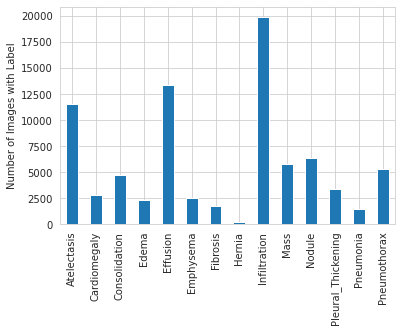

In [4]:
ax = all_xray_df[all_labels].sum().plot(kind='bar')
ax.set(ylabel = 'Number of Images with Label')

In [5]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification

# Todo
all_xray_df['pneumonia_class']=all_xray_df['Pneumonia'].apply(int).apply(str)
all_xray_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,pneumonia_class
91352,00022799_003.png,Atelectasis,3,22799,72,F,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
50764,00012842_001.png,,1,12842,46,M,PA,2770,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
22377,00005935_007.png,,7,5935,53,M,PA,2500,2048,0.171,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [6]:
all_xray_df['pneumonia_class'].value_counts()

0    110689
1      1431
Name: pneumonia_class, dtype: int64

#### The data is imbalanced

## Create your training and testing data:

In [7]:
def create_splits(vargs):
    
    train_data, val_data = skl.train_test_split(vargs, 
                                   test_size = 0.2, 
                                   stratify = vargs['pneumonia_class'])
    
    pne_indices=train_data[train_data['pneumonia_class']=='1'].index.tolist()
    nopne_indices=train_data[train_data['pneumonia_class']=='0'].index.tolist()
    np_sample = sample(nopne_indices,len(pne_indices))
    train_data = train_data.loc[pne_indices + np_sample]
    
    val_pne_indices=val_data[val_data['pneumonia_class']=='1'].index.tolist()
    val_nopne_indices=val_data[val_data['pneumonia_class']=='0'].index.tolist()
    v_np_sample = sample(val_nopne_indices,4*len(val_pne_indices))
    val_data = val_data.loc[val_pne_indices + v_np_sample]
    
    return train_data, val_data

In [8]:
train_df,val_df=create_splits(all_xray_df)

In [9]:
train_df['pneumonia_class'].astype('int').sum()/len(train_df)

0.5

We randomly chose a set of  pneumonia_class images using the sample() function that was the same length as the number of true pneumonia_class cases we had, and then we threw out the rest of the non pneumonia_class cases. Now our training dataset is balanced 50-50

In [10]:
val_df['pneumonia_class'].astype('int').sum()/len(val_df)

0.2

##### Our validation set more like 20-80 

In [11]:
print(f'Train set size: {len(train_df)}, valid set size: {len(val_df)}')

Train set size: 2290, valid set size: 1430


In [12]:
train_df['Patient Gender'].value_counts()

M    1314
F     976
Name: Patient Gender, dtype: int64

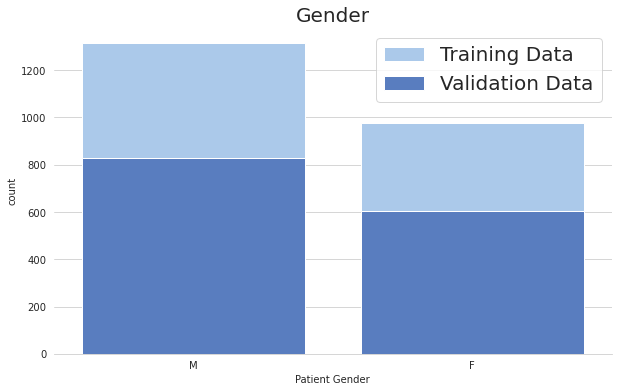

In [13]:

f, ax = plt.subplots(sharex=True,figsize=(10, 6))
sns.set_color_codes("pastel")
g=sns.countplot(x='Patient Gender',data=train_df, ax=ax, order = train_df['Patient Gender'].value_counts().index,color='b',label="Training Data")
sns.set_color_codes("muted")
g=sns.countplot(x='Patient Gender',data=val_df, ax=ax, color="b",label="Validation Data")
ax.legend( loc="upper right", frameon=True,fontsize=20)
#ax.set( ylabel="",xlabel="Number of decease")
ax.set_title("Gender",fontsize=20)      
sns.despine(left=True)

In [14]:
val_df['Patient Gender'].value_counts()

M    828
F    602
Name: Patient Gender, dtype: int64

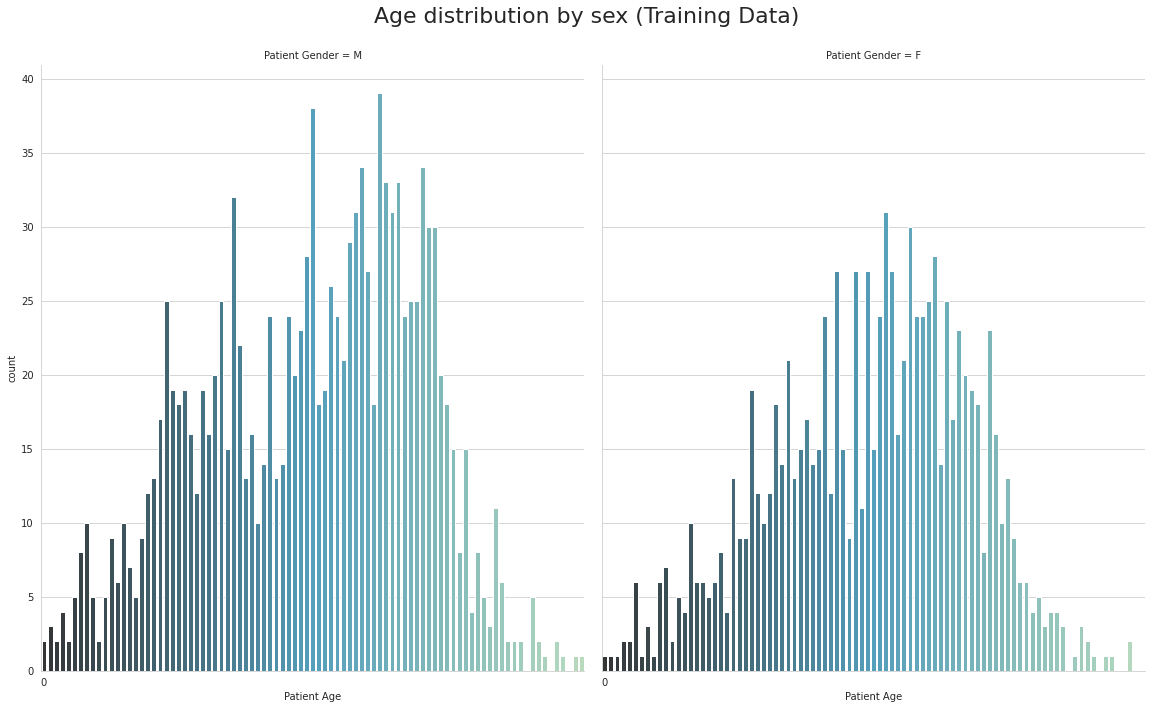

In [15]:
g = sns.factorplot(x="Patient Age", col="Patient Gender",data=train_df, kind="count",size=10, aspect=0.8,palette="GnBu_d");
g.set_xticklabels(np.arange(0,100));
g.set_xticklabels(step=10);
g.fig.suptitle('Age distribution by sex (Training Data)',fontsize=22);
g.fig.subplots_adjust(top=.9)

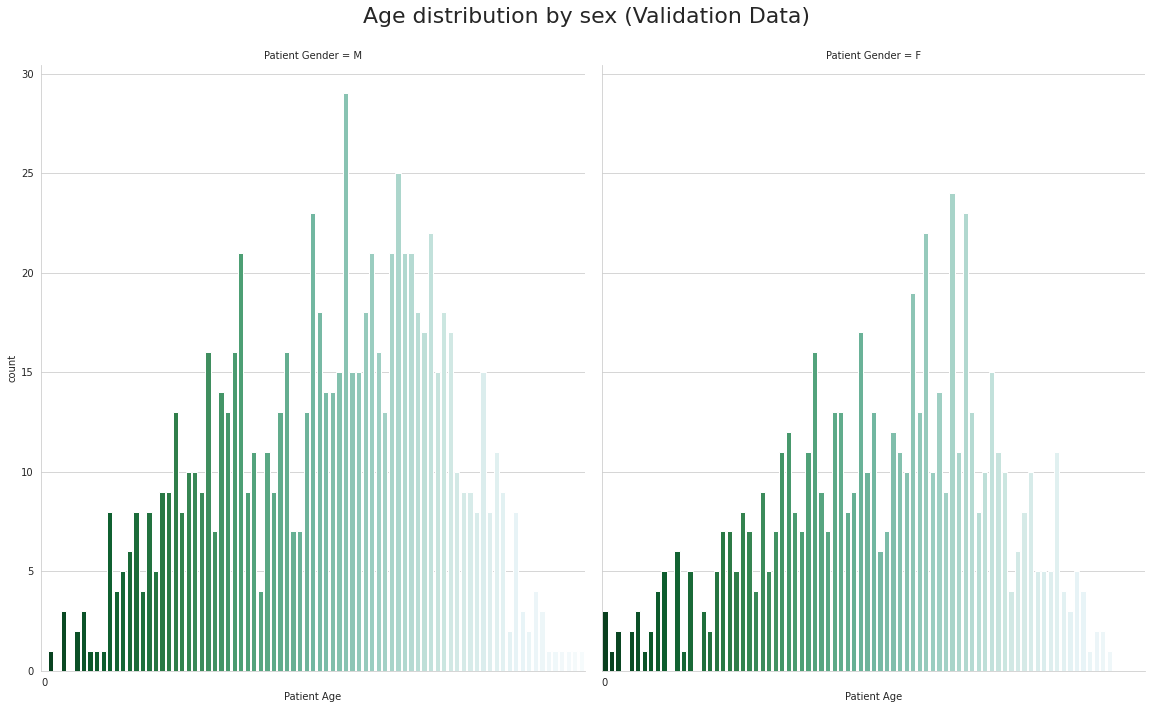

In [16]:
g = sns.factorplot(x="Patient Age", col="Patient Gender",data=val_df, kind="count",size=10, aspect=0.8,palette="BuGn_r");
g.set_xticklabels(np.arange(0,100));
g.set_xticklabels(step=10);
g.fig.suptitle('Age distribution by sex (Validation Data)',fontsize=22);
g.fig.subplots_adjust(top=.9)

In [17]:
train_df['pneumonia_class'].value_counts()

1    1145
0    1145
Name: pneumonia_class, dtype: int64

In [18]:
val_df['pneumonia_class'].value_counts()

0    1144
1     286
Name: pneumonia_class, dtype: int64

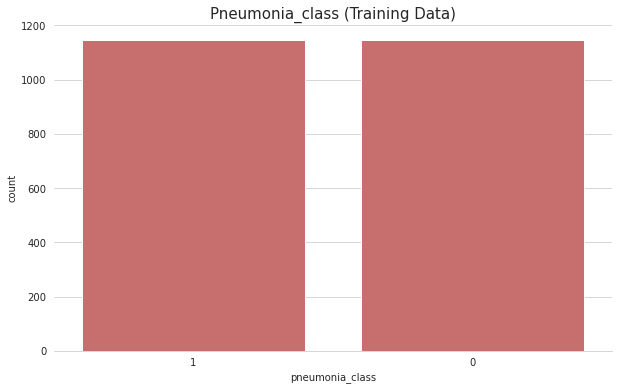

In [19]:
f, ax = plt.subplots(sharex=True,figsize=(10, 6))
sns.set_color_codes("muted")
g=sns.countplot(x='pneumonia_class',data=train_df, ax=ax, order = train_df['pneumonia_class'].value_counts().index,color='r',label="Training Data")
sns.set_color_codes("muted")

#ax.set( ylabel="",xlabel="Number of decease")
ax.set_title("Pneumonia_class (Training Data)",fontsize=15)      
sns.despine(left=True)

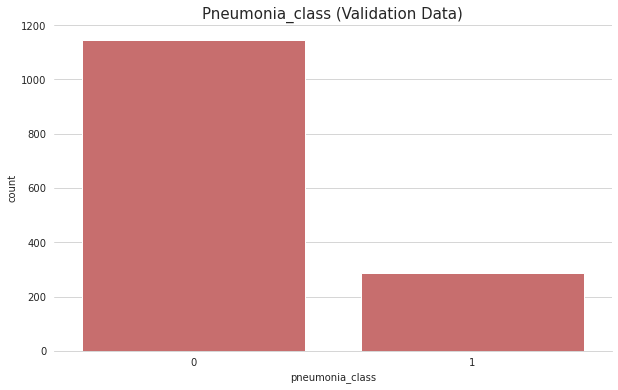

In [20]:
f, ax = plt.subplots(sharex=True,figsize=(10, 6))
sns.set_color_codes("muted")
g=sns.countplot(x='pneumonia_class',data=val_df, ax=ax, order = val_df['pneumonia_class'].value_counts().index,color='r',label="Training Data")
sns.set_color_codes("muted")

#ax.set( ylabel="",xlabel="Number of decease")
ax.set_title("Pneumonia_class (Validation Data)",fontsize=15)      
sns.despine(left=True)

# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [21]:
IMG_SIZE = (224, 224)

In [22]:
def my_image_augmentation(**vargs):
    my_idg = ImageDataGenerator(rescale=1. / 255.0,
                                samplewise_center=True,
                                samplewise_std_normalization= True, 
                                shear_range=0.1,
                                zoom_range=0.15,
                                rotation_range=5,
                                width_shift_range=0.1,
                                height_shift_range=0.05,
                                horizontal_flip=True, 
                                vertical_flip = False, 
                                fill_mode = 'reflect'
                               )
    
    return my_idg

def val_image_augmentation(**vargs):
    val_idg = ImageDataGenerator(samplewise_center=True,
                                samplewise_std_normalization= True, 
                               )
    
    return val_idg


def make_train_gen(**vargs):   
    my_train_idg = my_image_augmentation(**vargs)
    
    train_gen = my_train_idg.flow_from_dataframe(dataframe=train_df, 
                                         directory=None, 
                                          x_col ='path',
                                          y_col = 'pneumonia_class',
                                          class_mode = 'binary',
                                          target_size = IMG_SIZE, 
                                          batch_size = 32 
                                         )

    return train_gen


def make_val_gen(**vargs):
    my_val_idg = val_image_augmentation(**vargs)    
    val_gen = my_val_idg.flow_from_dataframe(dataframe = val_df, 
                                             directory=None, 
                                             x_col = 'path',
                                             y_col = 'pneumonia_class',
                                             class_mode = 'binary',
                                             target_size = IMG_SIZE, 
                                             batch_size = 256) 
    
    return val_gen

In [23]:
train_gen = make_train_gen()
val_gen = make_val_gen()
## May want to pull a single large batch of random validation data for testing after each epoch:
valX, valY = val_gen.next()

Found 2290 validated image filenames belonging to 2 classes.
Found 1430 validated image filenames belonging to 2 classes.


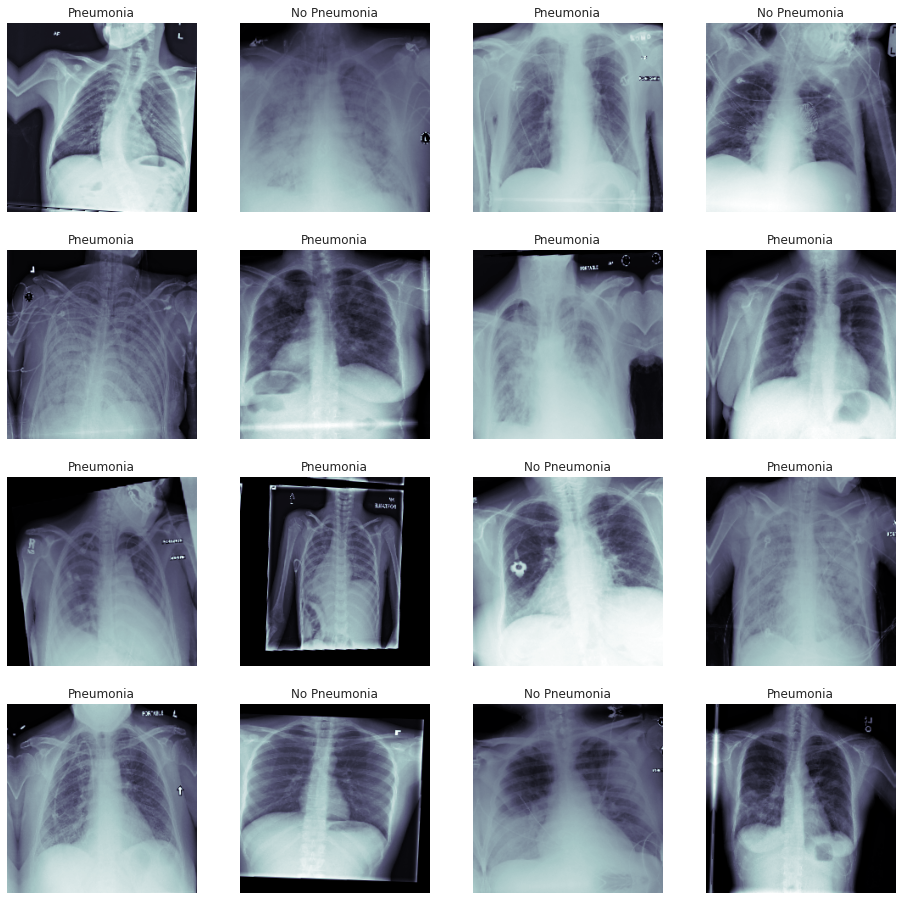

In [24]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

In [25]:
# # t_x, t_y = next(train_gen)

# fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
# for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
# #     mask = (data > 0.1) & (data < 0.9)
# #     d = data[mask].flatten()
#     c_ax.hist(c_x[:,:,0].flatten(), bins = 256, color='red')
    
#     if c_y == 1: 
#         c_ax.set_title('Pneumonia')
#     else:
#         c_ax.set_title('No Pneumonia')

# plt.show()

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [26]:
def load_pretrained_model(lay_of_interest):    
    model = VGG16(include_top=True, weights='imagenet')
    transfer_layer = model.get_layer(lay_of_interest)
    vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    
    # Todo
    # trainable
    for layer in vgg_model.layers[0:17]:
        layer.trainable = False
    
    print('VGG16 layers:')
    for layer in vgg_model.layers:
        print(layer.name, layer.trainable)
    
    return vgg_model


In [27]:
def build_my_model(model): 
    new_model = Sequential()
    new_model.add(vgg_model)
    new_model.add(Flatten())
    new_model.add(Dense(1024, activation='relu'))
    new_model.add(Dropout(0.4))
    new_model.add(Dense(512, activation='relu'))
    new_model.add(Dropout(0.3))
    new_model.add(Dense(256, activation='relu'))
    new_model.add(Dropout(0.2))
    new_model.add(Dense(128, activation='relu'))
    new_model.add(Dropout(0.1))
    new_model.add(Dense(1, activation='sigmoid'))
    ## Set our optimizer, loss function, and learning rate
    optimizer = Adam(lr=1e-4)
    loss = 'binary_crossentropy'
    metrics = ['binary_accuracy']
    new_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
    return new_model

In [28]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training
weight_path="{}_my_model.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, 
                              monitor= 'val_loss', 
                              verbose=1, 
                              save_best_only=True, 
                              mode= 'min', 
                              save_weights_only = True)

early = EarlyStopping(monitor= 'val_loss', 
                       mode= 'min', 
                       patience=5)

callbacks_list = [checkpoint, early]

### Start training! 

In [29]:
## build_my_model_1
vgg_model=load_pretrained_model('block5_pool')
my_model = build_my_model(vgg_model)
## Just run a single epoch to see how it does:
my_model.fit_generator(train_gen, validation_data = (valX, valY), 
                                  epochs = 1)

553467904/553467096 [==============================] - 6s 0us/step
VGG16 layers:
input_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 True
block5_pool True
Epoch 1/1
72/72 [==============================] - 96s 1s/step - loss: 0.7266 - binary_accuracy: 0.5454 - val_loss: 0.7319 - val_binary_accuracy: 0.4805


In [30]:
my_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              25691136  
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)              

In [31]:
## train your model
history = my_model.fit_generator(train_gen, 
                          validation_data = (valX, valY), 
                          epochs = 20, 
                          callbacks = callbacks_list)

Epoch 1/20
72/72 [==============================] - 88s 1s/step - loss: 0.6746 - binary_accuracy: 0.5869 - val_loss: 0.8312 - val_binary_accuracy: 0.3555

Epoch 00001: val_loss improved from inf to 0.83116, saving model to xray_class_my_model.best.hdf5
Epoch 2/20
72/72 [==============================] - 62s 855ms/step - loss: 0.6652 - binary_accuracy: 0.5983 - val_loss: 0.6072 - val_binary_accuracy: 0.6719

Epoch 00002: val_loss improved from 0.83116 to 0.60718, saving model to xray_class_my_model.best.hdf5
Epoch 3/20
72/72 [==============================] - 60s 828ms/step - loss: 0.6407 - binary_accuracy: 0.6354 - val_loss: 0.6368 - val_binary_accuracy: 0.6484

Epoch 00003: val_loss did not improve from 0.60718
Epoch 4/20
72/72 [==============================] - 60s 839ms/step - loss: 0.6286 - binary_accuracy: 0.6511 - val_loss: 0.6538 - val_binary_accuracy: 0.6016

Epoch 00004: val_loss did not improve from 0.60718
Epoch 5/20
72/72 [==============================] - 61s 841ms/step - 

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [32]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
pred_Y = my_model.predict(valX, batch_size = 32, verbose = True)

256/256 [==============================] - 2s 9ms/step


In [33]:
# make a prediction
ynew = my_model.predict_classes(valX)
# show the inputs and predicted outputs

In [34]:
print ('Confusion Matrix :')
print(confusion_matrix(valY, ynew)) 

Confusion Matrix :
[[131  65]
 [ 19  41]]


In [35]:
tn, fp, fn, tp = confusion_matrix(valY, ynew).ravel()
(tn, fp, fn, tp)

(131, 65, 19, 41)

In [36]:
print('Report : ')
print(classification_report(valY, ynew))

Report : 
              precision    recall  f1-score   support

         0.0       0.87      0.67      0.76       196
         1.0       0.39      0.68      0.49        60

    accuracy                           0.67       256
   macro avg       0.63      0.68      0.63       256
weighted avg       0.76      0.67      0.70       256



In [37]:
# https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/
def plot_auc(t_y, p_y):
    f, ax = plt.subplots(figsize=(10, 6))
    plt.style.use('bmh')
    fpr, tpr, thresholds = roc_curve(t_y, p_y, pos_label=1)
    plt.plot(fpr, tpr, color='red', lw=2)
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    plt.xlabel('FPR',fontsize=12)
    plt.ylabel('TPR',fontsize=12)
    plt.title('ROC Curve',fontsize=15)  
    plt.show()


def plot_pr(t_y, p_y):
    f, ax = plt.subplots(figsize=(10, 6))
    plt.style.use('bmh')
    axes = plt.gca()
    precision, recall, thresholds = precision_recall_curve(t_y, p_y, pos_label=1)
    plt.step(recall, precision, color='b', alpha=0.7, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.7, color='r')
    plt.xlabel('Recall' ,fontsize=12)
    plt.ylabel('Precision',fontsize=12)
    axes.set_ylim([0,0.6])
    plt.title('Precision-Recall Curve',fontsize=15)
    plt.show()


#Also consider plotting the history of your model training:

def plot_history(history):
    N = len(history.history["loss"])
    f, ax = plt.subplots(figsize=(10, 6))
    plt.style.use('bmh')
    plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), history.history["binary_accuracy"], label="train_acc")
    plt.plot(np.arange(0, N), history.history["val_binary_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy on Dataset" ,fontsize=15)
    plt.xlabel("Epoch #" ,fontsize=12)
    plt.ylabel("Loss/Accuracy" ,fontsize=12)
    plt.legend(loc="upper left")

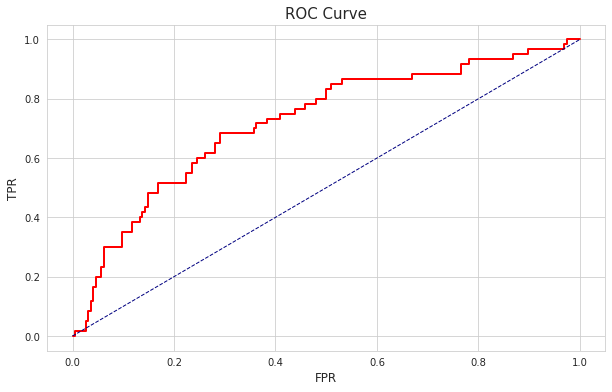

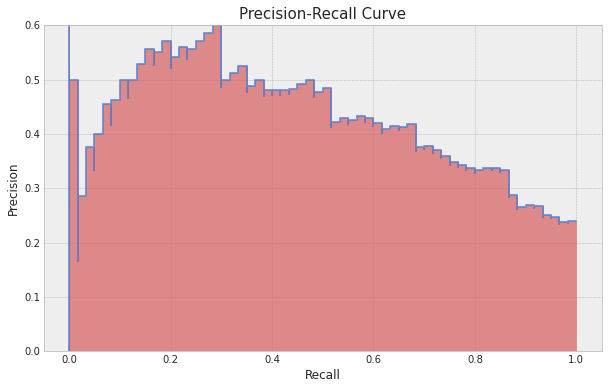

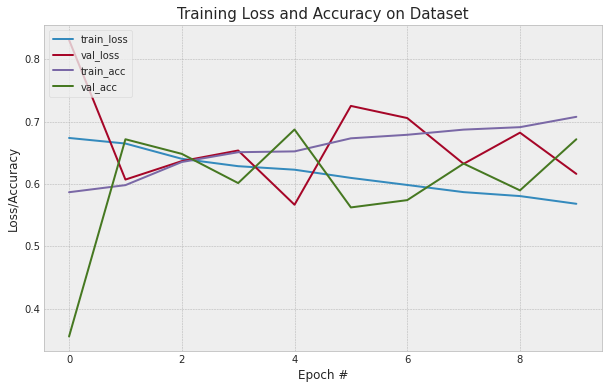

In [38]:
## plot figures
plot_auc(valY, pred_Y)
## plot figures
plot_pr(valY, pred_Y)
# Todo
plot_history(history)

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

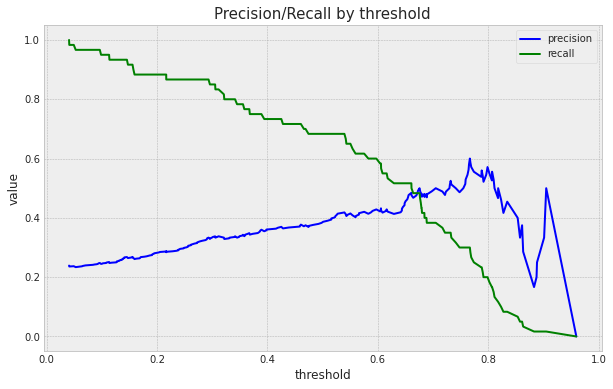

In [39]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.

# Todo
precision, recall, thresholds = precision_recall_curve(valY, pred_Y, pos_label=1)
f, ax = plt.subplots(figsize=(10, 6))
plt.style.use('bmh')
plt.plot(thresholds, precision[:-1], color='blue', lw=2, label='precision')
plt.plot(thresholds, recall[:-1], color='green', lw=2, label='recall')
plt.legend()
plt.xlabel('threshold',fontsize=12)
plt.ylabel('value',fontsize=12)
plt.title('Precision/Recall by threshold',fontsize=15)
plt.show()

In [40]:
def calculate_f1(precision,recall):
    return 2*(precision*recall)/(precision+recall)
    
max(calculate_f1(precision,recall))

0.5189873417721519

In [41]:
t = thresholds[np.argmax(calculate_f1(precision,recall))]

In [42]:
print(f'Threshold for maximum f1-score: {t}')

Threshold for maximum f1-score: 0.9597315788269043


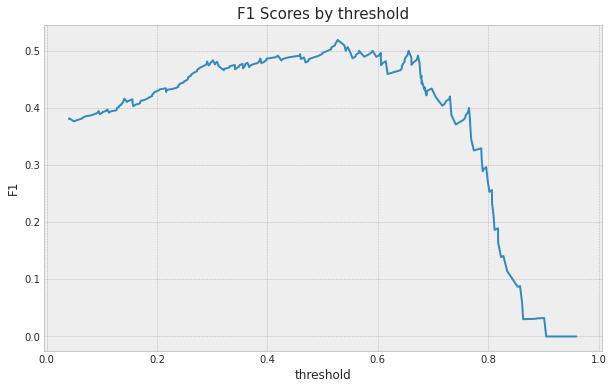

In [43]:
import math
def f1_score(threshold):
    for i,t in enumerate(thresholds):
        if t > threshold:
            f1score = calculate_f1(precision[i], recall[i])
            if not math.isnan(f1score):
                return f1score
            else: 
                return 0
    return 0

f1_scores = [f1_score(t) for t in thresholds]
f, ax = plt.subplots(figsize=(10, 6))
plt.style.use('bmh')
plt.plot(thresholds, f1_scores)
plt.title('F1 Scores by threshold',fontsize=15)
plt.xlabel('threshold' ,fontsize=12)
plt.ylabel('F1',fontsize=12)
plt.show()

In [ ]:
# for i,t in enumerate(thresholds):
#     f1score = calculate_f1(precision[i], recall[i])
#     if not math.isnan(f1score):
#         print(t , ":", f1score)

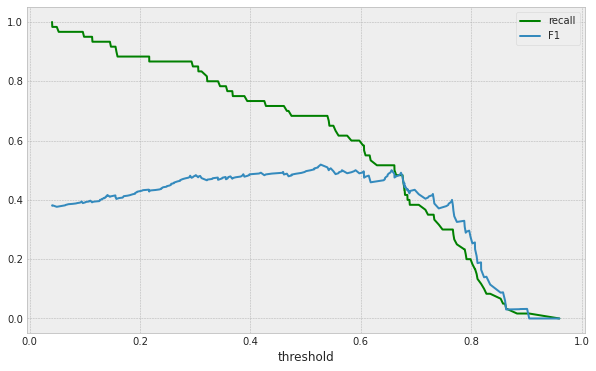

In [45]:
f, ax = plt.subplots(figsize=(10, 6))
plt.style.use('bmh')
plt.plot(thresholds, recall[:-1], color='green', lw=2, label='recall')
plt.plot(thresholds, f1_scores, label='F1')
plt.xlabel('threshold',fontsize=12)
plt.legend()
plt.show()

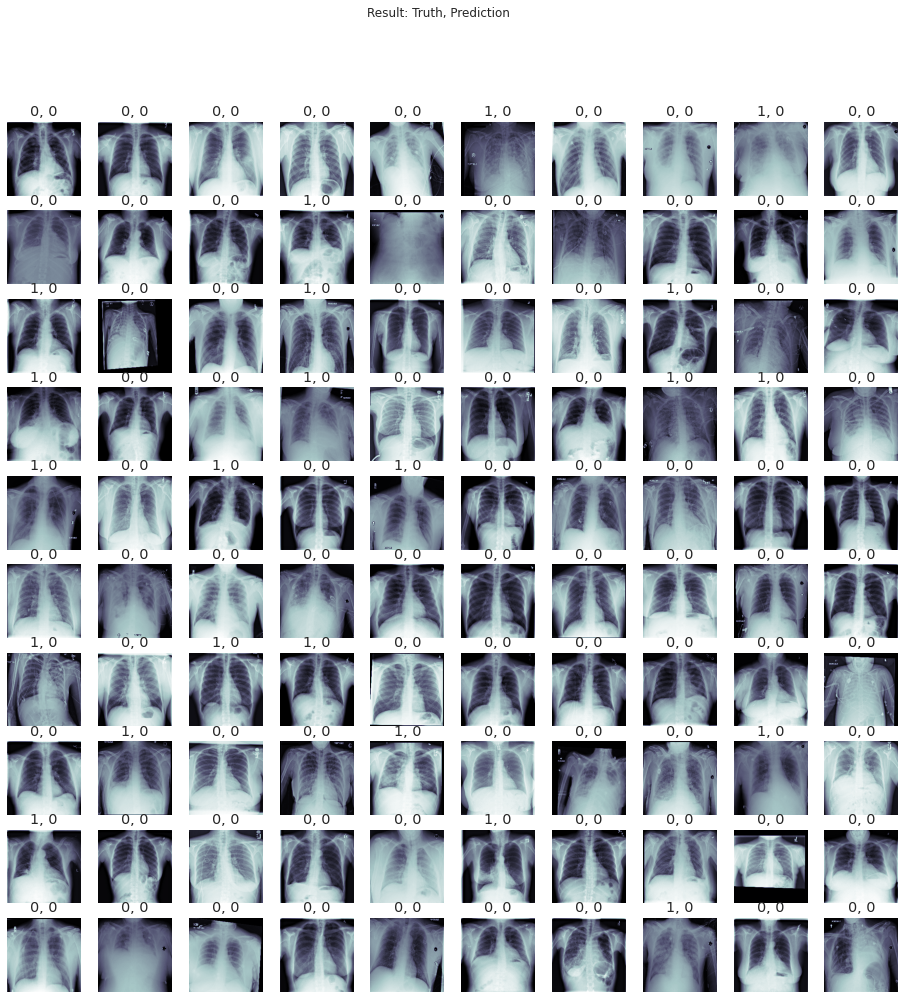

In [46]:
## Let's look at some examples of true vs. predicted with our best model: 
index=np.random.choice(range(200), 100, replace=False)
# Todo
# real, predicted
fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
fig.suptitle('Result: Truth, Prediction')
i = 0
for (c_x, c_y, c_ax) in zip(valX[index], valY[index], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if pred_Y[i] > t:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_Y[i] >  t: 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1



In [47]:
## Just save model architecture to a .json:
model_json = my_model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)